In [1]:
import pandas as pd  
import numpy as np
import os
from scipy.stats import kstest
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from PIL import Image
from IPython import display
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
np.random.seed(233)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
file_path = ["./Dataset/" + file_name for file_name in os.listdir("./Dataset")]
Mon_map = {
        'Dec': '12',
        'Nov': '11',
        'Oct': '10',
        'Sep': '09',
        'Aug': '08',
        'Jul': '07',
        'Jun': '06',
        'May': '05',
        'Apr': '04',
        'Mar': '03',
        'Feb': '02',
        'Jan': '01'
    }
years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]

In [3]:
if 'output' not in os.listdir():
    os.system("mkdir output")
for year in years:
    if year not in os.listdir("./output"):
        os.system(f"mkdir ./output/{year}")

## 💾 Data Preparation

In [4]:
# -- all data
yearly_data = []
for year in years:
    temp = pd.DataFrame(columns=['Date', 'Price', 'ticker'])
    for file in file_path:
        df = pd.read_csv(file).loc[:,["Date", "Price"]]
        df["Date"] = df["Date"].apply(lambda x: x[-4:] + "-" + Mon_map[x[:3]] + "-" + x[4:6])
        df["ticker"] = file[10:13]
        lis = df.Date.apply(lambda x: x[0:4] == year)
        temp = pd.concat([temp, df[lis]])
    yearly_data.append(temp)

In [5]:
# -- all years' close price
df = yearly_data[0]
for i in range(1, 11):
    df = df.append(yearly_data[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30693 entries, 2770 to 532
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    30693 non-null  object
 1   Price   30693 non-null  object
 2   ticker  30693 non-null  object
dtypes: object(3)
memory usage: 959.2+ KB


In [6]:
# -- set index
all_years_panel_data = df.set_index('Date')
all_years_panel_data.head

<bound method NDFrame.head of             Price ticker
Date                    
2010-12-31  54.23    QQQ
2010-12-30  54.43    QQQ
2010-12-29  54.56    QQQ
2010-12-28  54.44    QQQ
2010-12-27  54.54    QQQ
...           ...    ...
2020-01-08  30.73    XLF
2020-01-07  30.53    XLF
2020-01-06  30.73    XLF
2020-01-03  30.75    XLF
2020-01-02  31.08    XLF

[30693 rows x 2 columns]>

In [7]:
# -- change data formate, table contains all years' data
all_years_ts_data = all_years_panel_data.pivot(columns='ticker')
all_years_ts_data.columns = [col[1] for col in all_years_ts_data.columns]
all_years_ts_data.head()

QQQ    VNQ    VOX    XLB    XLE    XLF    XLI    XLP    XLU  \
Date                                                                        
2010-01-04  46.23  44.55  57.72  34.02   57.1  11.93  28.32  26.67  31.08   
2010-01-05  46.23   44.5  58.11  34.13  57.57  12.15  28.42  26.68  30.71   
2010-01-06  45.95  44.42  57.19  34.71  58.26  12.17  28.48  26.66  30.89   
2010-01-07  45.98   44.9  56.98  34.44  58.17  12.43  28.79  26.66  30.75   
2010-01-08  46.36  44.57  56.72  34.92  58.55  12.36  29.25  26.57  30.72   

              XLV    XLY  
Date                      
2010-01-04  31.41   30.0  
2010-01-05   31.1  30.11  
2010-01-06  31.42  30.15  
2010-01-07  31.52   30.4  
2010-01-08  31.57  30.39

In [8]:
# -- choose data of identical year
individual_year = "2017"
individual_year_ts_data = all_years_ts_data.loc[all_years_ts_data.index.str.contains(individual_year)]
individual_year_ts_data.head()

QQQ    VNQ     VOX    XLB    XLE    XLF    XLI    XLP    XLU  \
Date                                                                          
2017-01-03  119.54   82.8  103.42  49.99  73.96  23.51  62.59   51.9  48.45   
2017-01-04  120.19  84.01  104.13  50.72   73.8   23.7  62.96   51.9  48.63   
2017-01-05  120.87  84.28  103.37  50.57  73.62  23.46  62.78  52.07  48.68   
2017-01-06  121.93  84.29  101.94  50.62  73.69  23.54  63.14  52.12  48.83   
2017-01-09  122.33  83.53  100.95  50.61  72.62  23.38  62.65   51.7  48.19   

              XLV    XLY  
Date                      
2017-01-03  69.39  81.88  
2017-01-04  69.93  82.97  
2017-01-05  70.29  82.91  
2017-01-06  70.49  83.32  
2017-01-09  70.79  83.25

## 📊 EDA

In [9]:
# 11 kinds of colors for 11 tickers
colors =[  'springgreen', 'lightseagreen', 'darkcyan', 
            'steelblue', 'yellowgreen', 'firebrick', 
            'fuchsia', 'darkorange', 'tomato', 'plum', 'crimson']

### 💵1. Price

#### 1.1 Fluctuation

Text(0, 0.5, 'price in $')

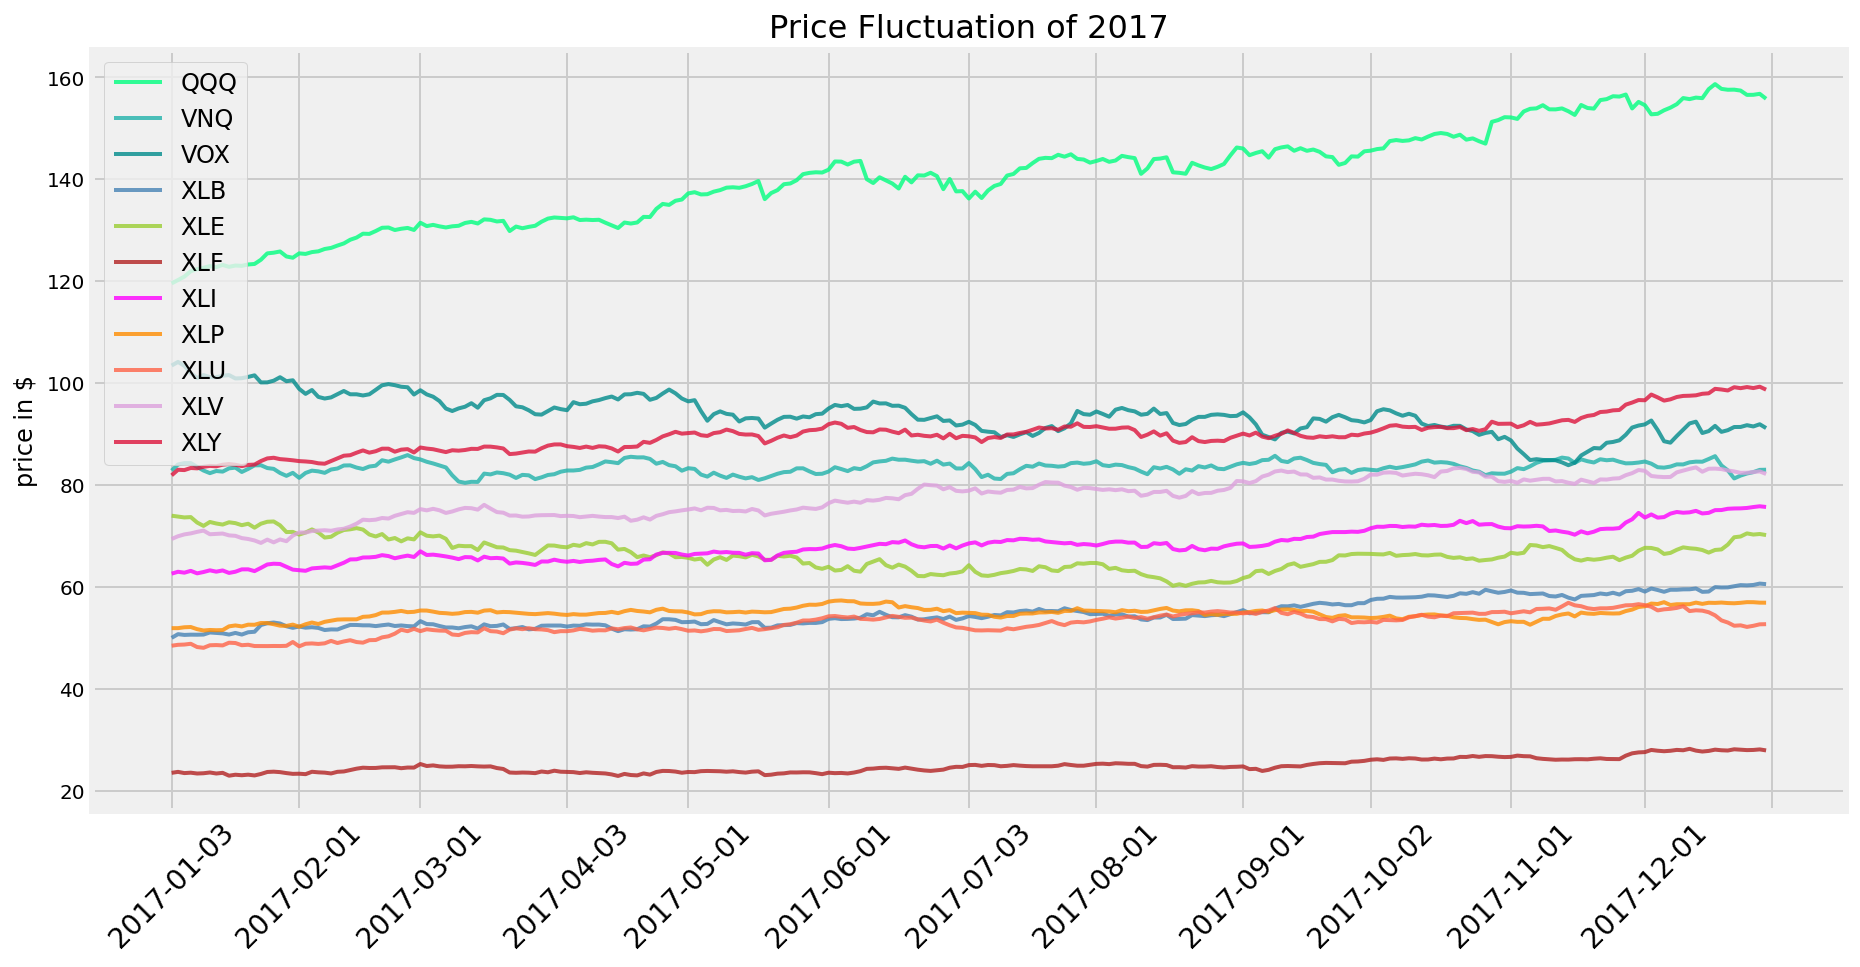

In [10]:
# -- draw price fluctuation (one year)
count = [0 for _ in range(12)]
xlabels_one_year = []
for date in list(individual_year_ts_data.index):
    if not count[int(date[5:7])-1]:
        xlabels_one_year.append(date)
        count[int(date[5:7])-1] += 1
    else:
        xlabels_one_year.append(" ")
plt.figure(figsize=(14, 7))
for c, color in zip(individual_year_ts_data.columns.values, colors):
    plt.plot(individual_year_ts_data.index, individual_year_ts_data[c], lw=2, alpha=0.8,label=c, color = color)
plt.xticks(xlabels_one_year, rotation = 45, fontsize=14)
plt.title(f"Price Fluctuation of {individual_year}", fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

In [11]:
all_years_ts_data['Y-M'] = list(pd.Series(all_years_ts_data.index).apply(lambda x: x[:7]))
price_groups = all_years_ts_data.groupby('Y-M')
mons = []
price = [[[], [], []] for _ in range(11)] # each ticker: 0.25 quantile, median, 0.75 quantile 

In [12]:
ticker_columns = list(all_years_ts_data.columns)[:-1]
for group in price_groups:
    mons.append(group[0])
    for ticker in ticker_columns: # 11 tickers
        price[ticker_columns.index(ticker)][0].append(group[1][ticker].quantile(0.25))
        price[ticker_columns.index(ticker)][1].append(group[1][ticker].quantile(0.5))
        price[ticker_columns.index(ticker)][2].append(group[1][ticker].quantile(0.75))

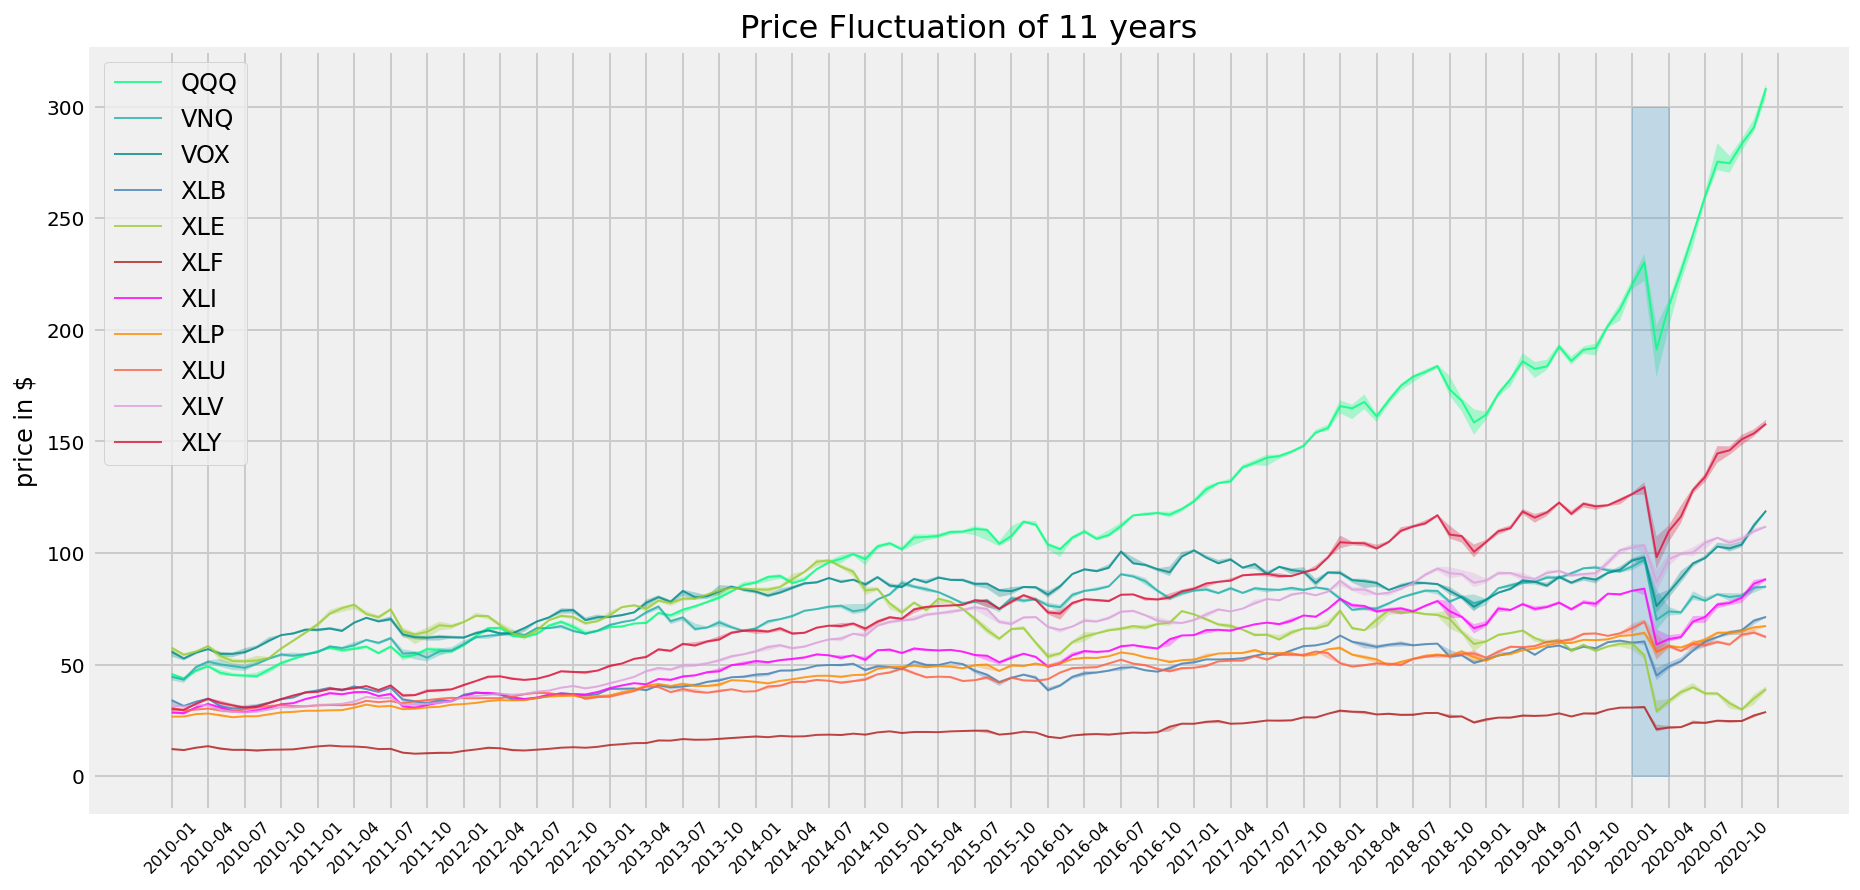

In [13]:
# -- draw price fluctuation (11 years)
count = ['01', '04', '07', '10'] # x-labels, every season
xlabels_all_years = []
for date in list(mons):
    if date[5:] in count:
        xlabels_all_years.append(date)
        count.append(date)
    else:
        xlabels_all_years.append(" ")
plt.figure(figsize=(14, 7))
for c, color in zip(price, colors):
    plt.plot(mons, c[1], lw=1, alpha=0.8,label=ticker_columns[price.index(c)], color = color)
    plt.fill_between(mons, c[2], c[0], facecolor=colors[price.index(c)], alpha=0.3) 
plt.xticks(xlabels_all_years, rotation = 45, fontsize=8)
plt.title(f"Price Fluctuation of 11 years", fontsize=16)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')
plt.fill_between(('2020-01', '2020-04'), 300, color='#539ecd', alpha = 0.3) # COVID-19 drawback area

#### 1.2 Correlation

In [14]:
price_corr_matrix_one_year = individual_year_ts_data.apply(lambda x: x.astype(float)).corr()
price_corr_matrix_all_years = all_years_ts_data.drop('Y-M', axis = 1).apply(lambda x: x.astype(float)).corr()

<AxesSubplot:title={'center':'11 Years'}>

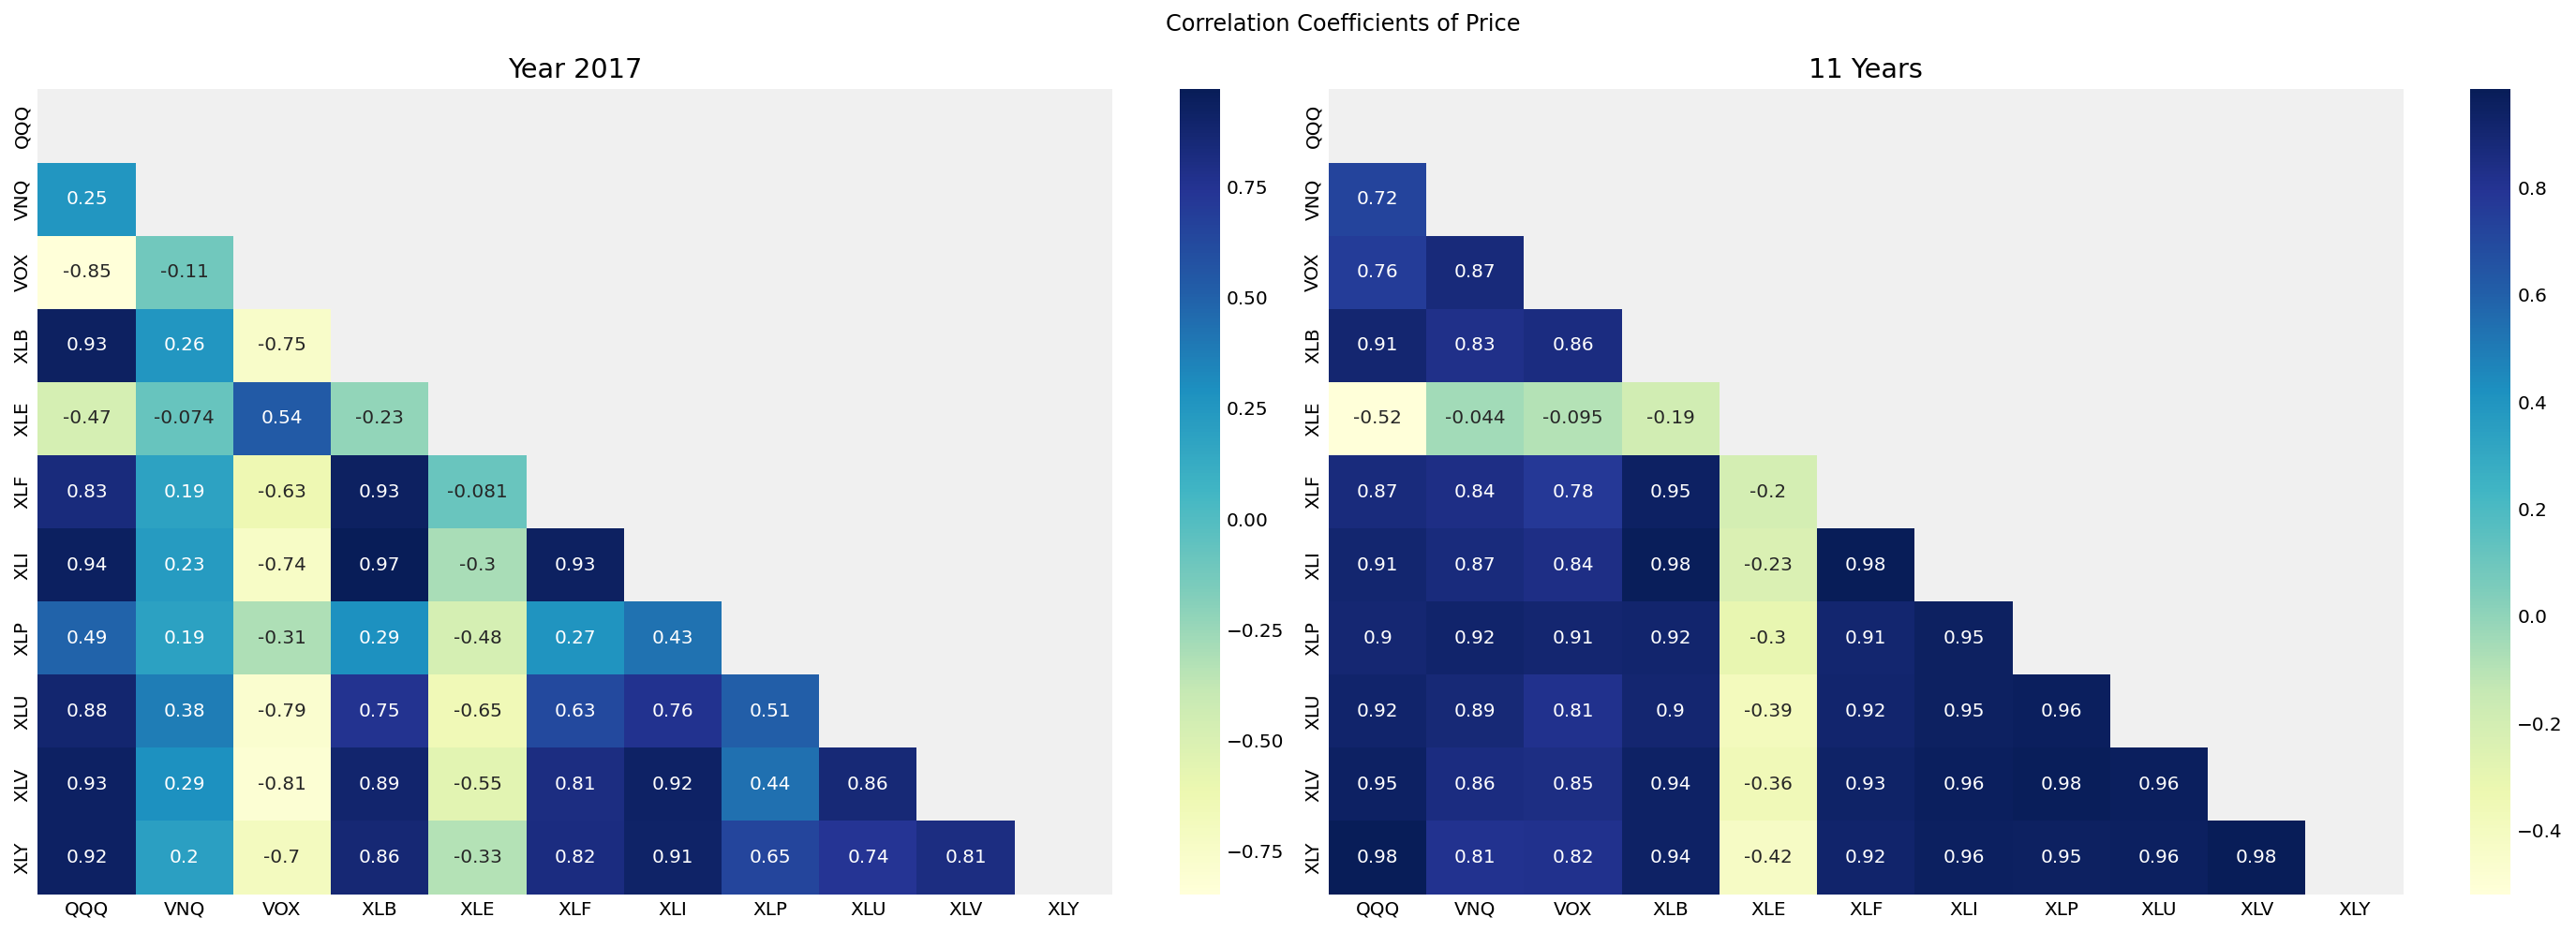

In [15]:
mask = np.zeros_like(price_corr_matrix_one_year)
mask[np.triu_indices_from(mask)] = True
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7), tight_layout = True)
plt.suptitle("Correlation Coefficients of Price")
axes[0].set_title(f"Year {individual_year}")
sns.heatmap(price_corr_matrix_one_year, ax=axes[0], mask=mask, annot=True, cmap="YlGnBu")
axes[1].set_title("11 Years")
sns.heatmap(price_corr_matrix_all_years, ax=axes[1], mask=mask, annot=True, cmap="YlGnBu")

### 🧧2. Returns 

#### 2.1 Fluctuation and Distribution

In [16]:

returns_one_year_ts_data = individual_year_ts_data.pct_change().dropna()
returns_all_years_ts_data = all_years_ts_data.drop('Y-M', axis = 1).pct_change().dropna()
days_num = returns_all_years_ts_data.shape[0]
returns_all_years_panel_data = pd.DataFrame({'return': returns_all_years_ts_data['QQQ'], 'ticker': ['QQQ' for i in range(days_num)]})
for ticker in ticker_columns[1:]:
    returns_all_years_panel_data = returns_all_years_panel_data.append(pd.DataFrame({'return': returns_all_years_ts_data[ticker], 'ticker': [ticker for i in range(days_num)]}))

In [17]:
returns_all_years_ts_data.head()

QQQ       VNQ       VOX       XLB       XLE       XLF  \
Date                                                                     
2010-01-05  0.000000 -0.001122  0.006757  0.003233  0.008231  0.018441   
2010-01-06 -0.006057 -0.001798 -0.015832  0.016994  0.011985  0.001646   
2010-01-07  0.000653  0.010806 -0.003672 -0.007779 -0.001545  0.021364   
2010-01-08  0.008264 -0.007350 -0.004563  0.013937  0.006533 -0.005632   
2010-01-11 -0.004098  0.005834  0.000882 -0.005441 -0.001366  0.000809   

                 XLI       XLP       XLU       XLV       XLY  
Date                                                          
2010-01-05  0.003531  0.000375 -0.011905 -0.009869  0.003667  
2010-01-06  0.002111 -0.000750  0.005861  0.010289  0.001328  
2010-01-07  0.010885  0.000000 -0.004532  0.003183  0.008292  
2010-01-08  0.015978 -0.003376 -0.000976  0.001586 -0.000329  
2010-01-11  0.010940  0.002635  0.010417  0.005702 -0.001974

In [18]:
returns_all_years_panel_data.head()

return ticker
Date                       
2010-01-05  0.000000    QQQ
2010-01-06 -0.006057    QQQ
2010-01-07  0.000653    QQQ
2010-01-08  0.008264    QQQ
2010-01-11 -0.004098    QQQ

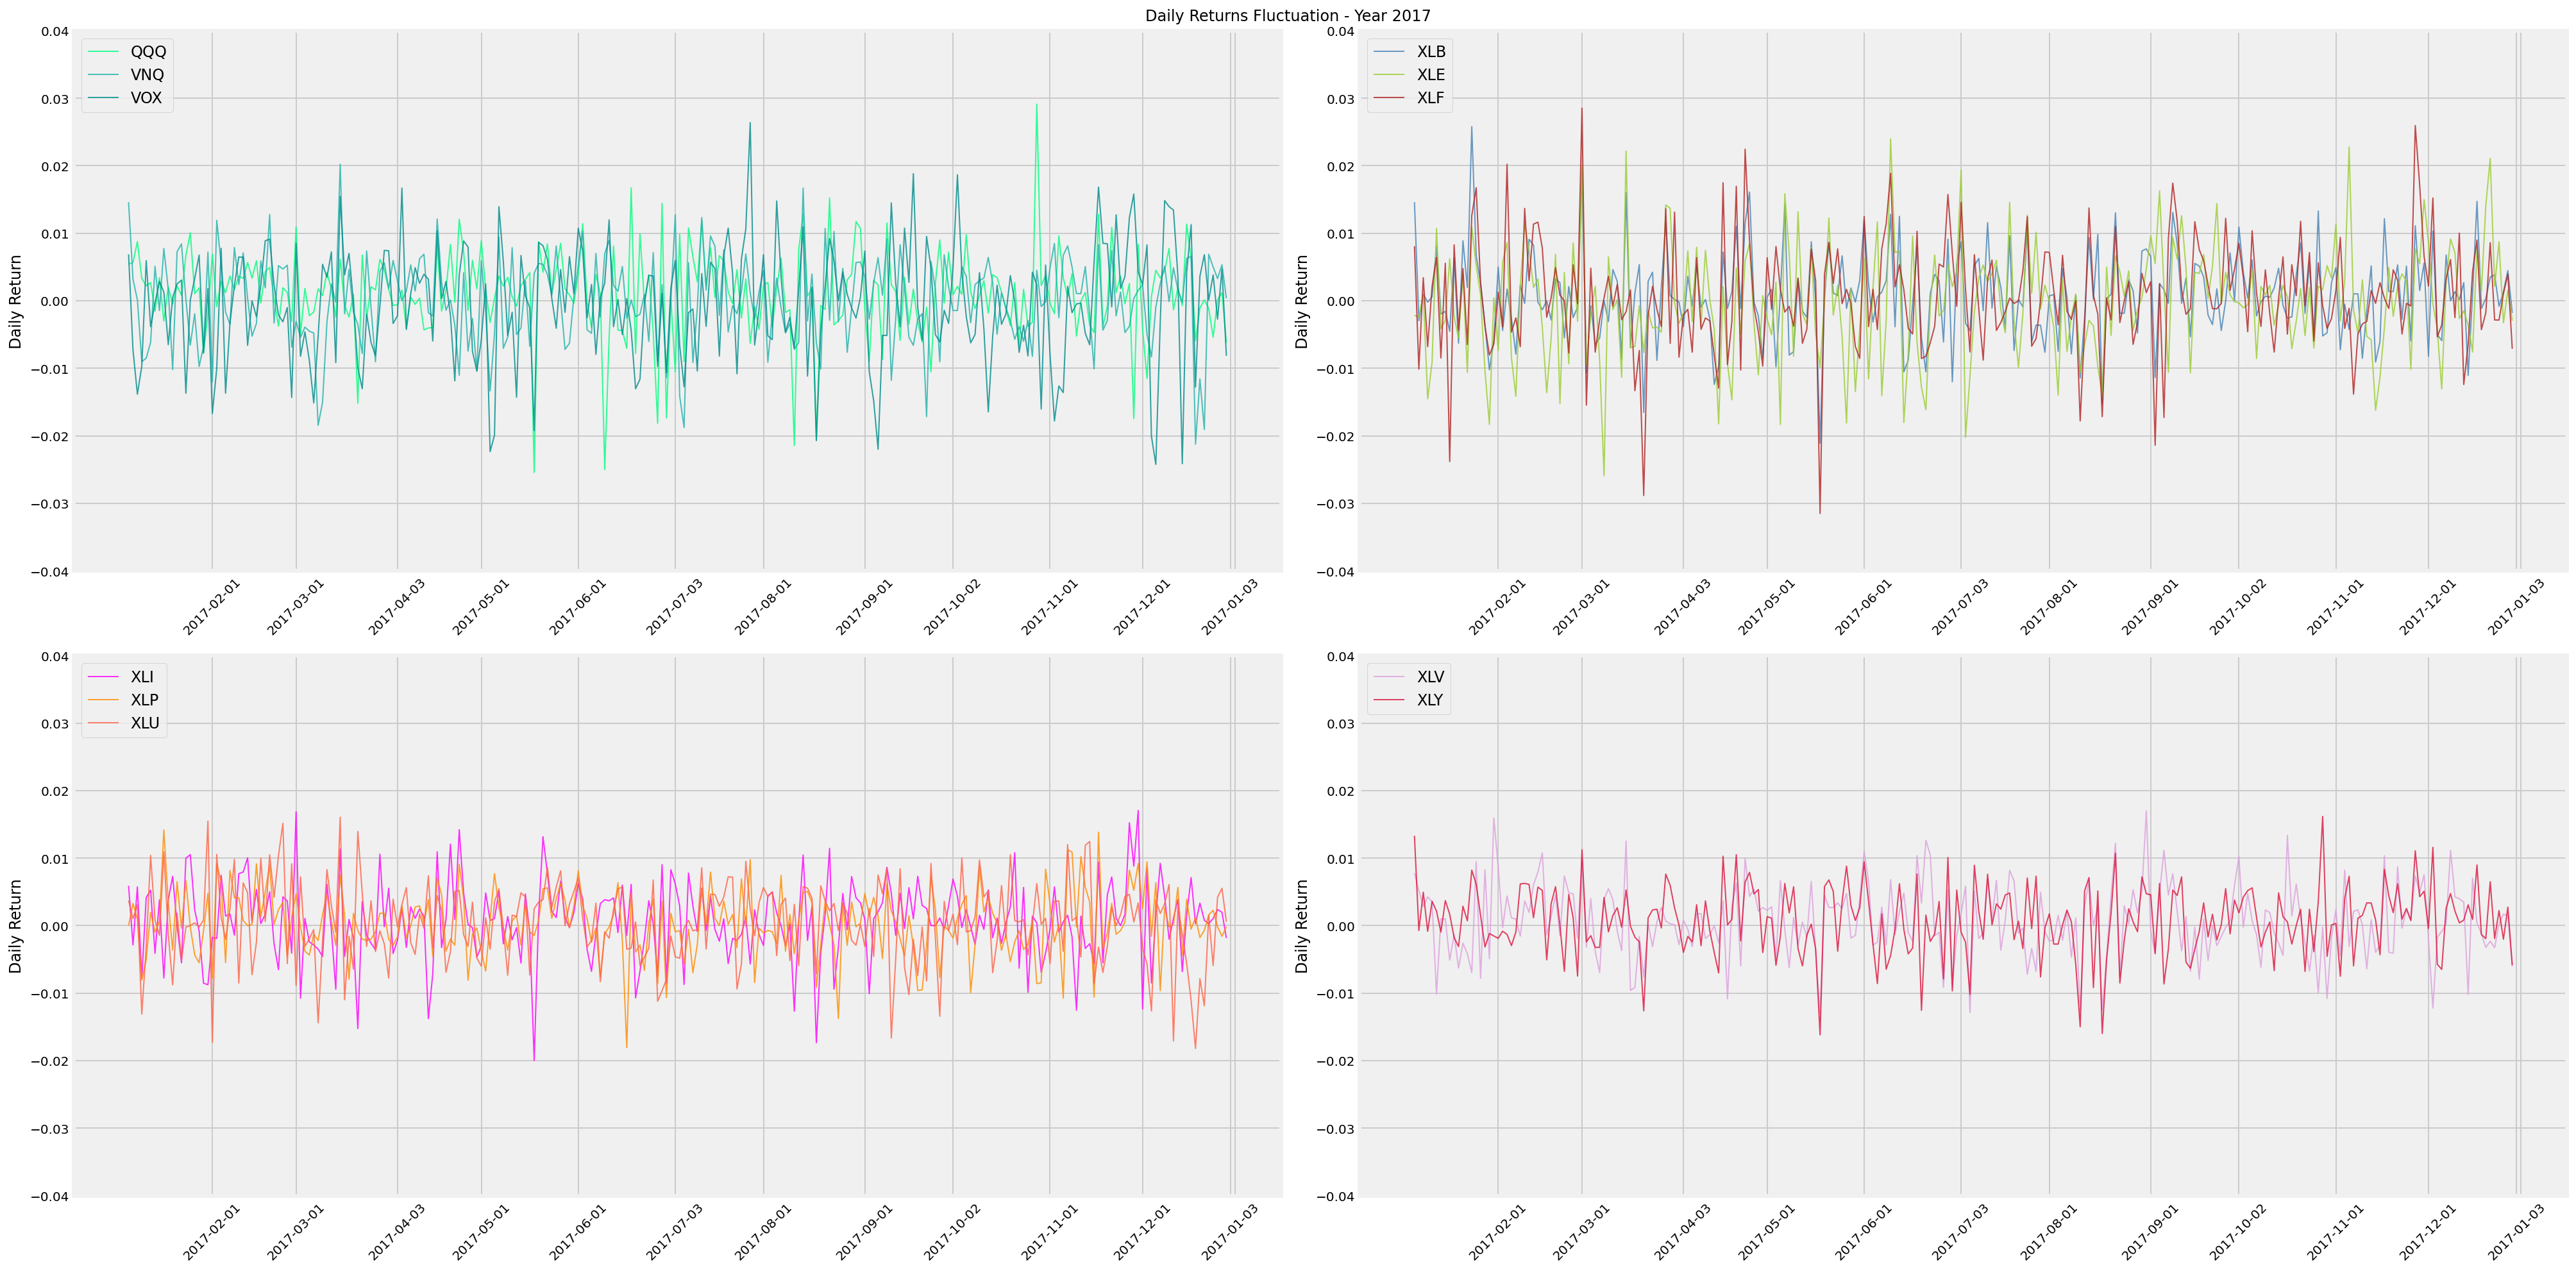

In [19]:
# -- draw returns fluctuation
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(28,14), tight_layout = True)
plt.xticks(rotation = 45)
plt.suptitle(f"Daily Returns Fluctuation - Year {individual_year}")
for subplot in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    No = subplot[0]*2 + subplot[1]
    ax = axes[subplot[0]][subplot[1]]
    for c in returns_one_year_ts_data.columns[No*3: min((No+1)*3, len(returns_one_year_ts_data.columns))]:
        ax.plot(returns_one_year_ts_data.index, returns_one_year_ts_data[c], lw=1, alpha=0.8, label=c, color=colors[ticker_columns.index(c)])
    ax.set_xticks(xlabels_one_year)
    ax.set_ylabel('Daily Return')
    ax.set_ylim(-0.04, 0.04)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left', fontsize=12)
plt.show()

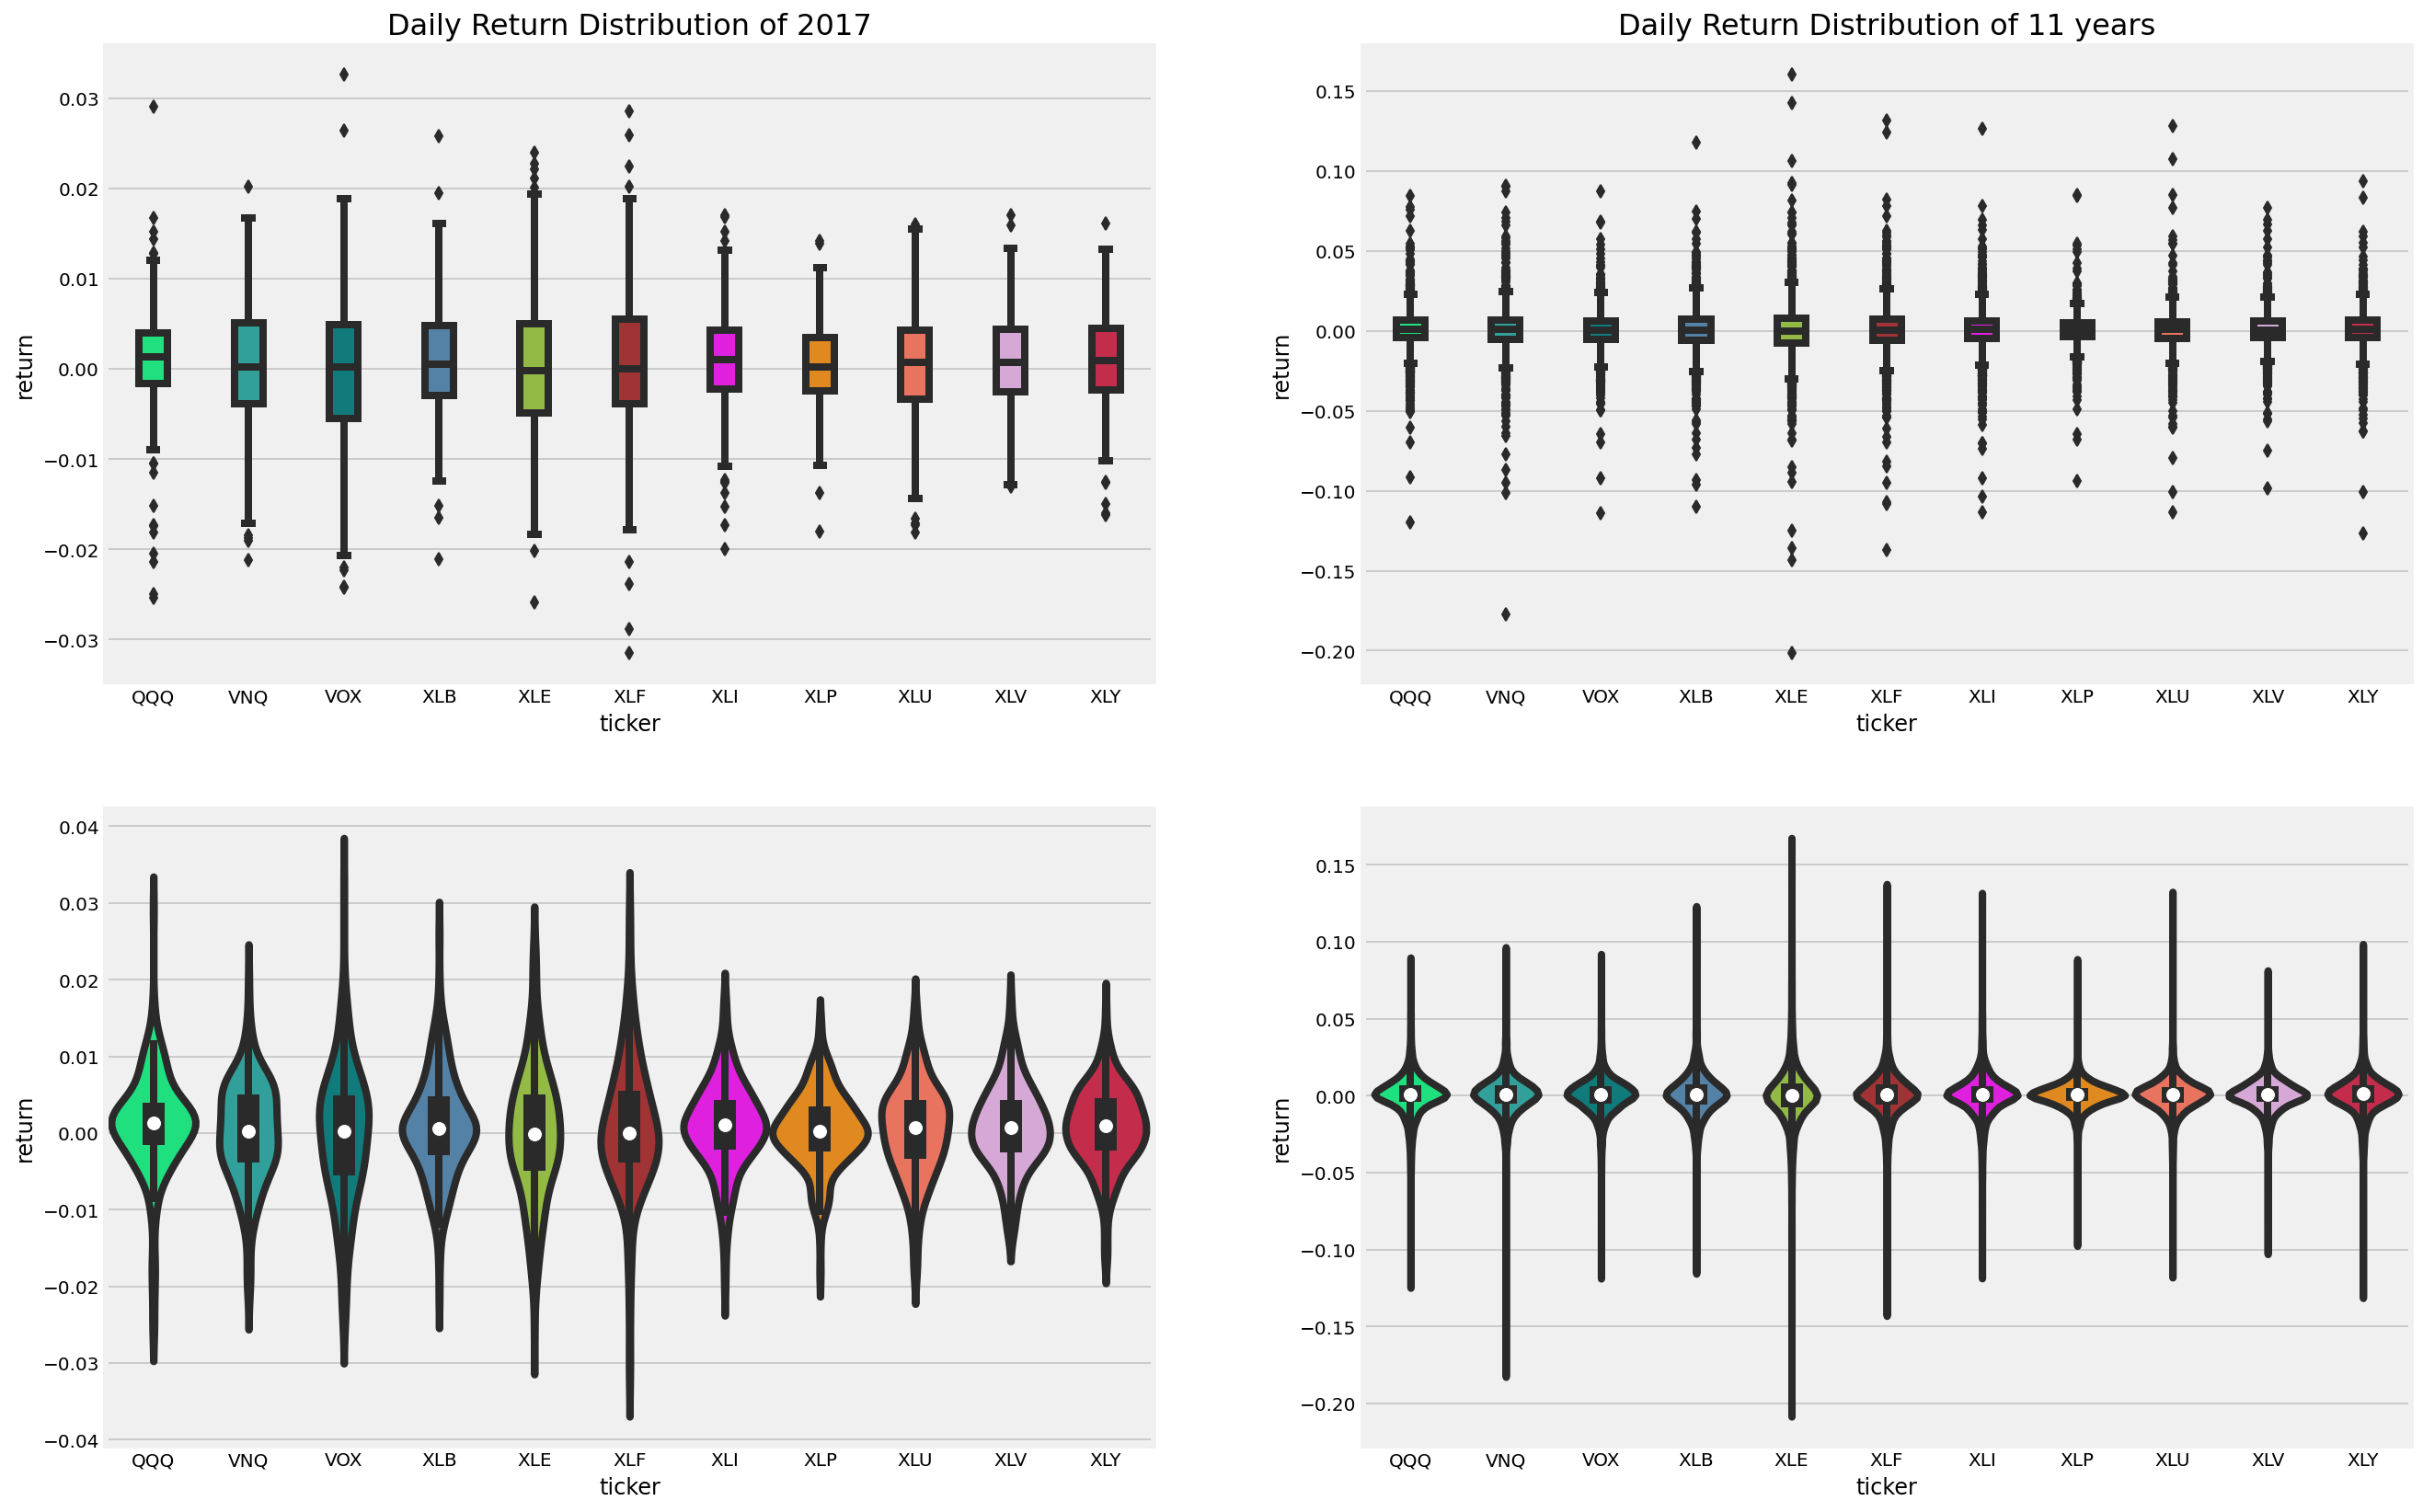

In [20]:
returns_one_year_panel_data = returns_all_years_panel_data[returns_all_years_panel_data.index.str.contains('2017')]
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize=(20, 14))
axes[0][0].set_title("Daily Return Distribution of 2017", fontsize=16)
sns.boxplot(ax = axes[0][0], x=returns_one_year_panel_data["ticker"], y=returns_one_year_panel_data["return"], width=0.3, palette=colors)
sns.violinplot(ax = axes[1][0], x=returns_one_year_panel_data["ticker"], y=returns_one_year_panel_data["return"], width=1, palette=colors)

axes[0][1].set_title("Daily Return Distribution of 11 years", fontsize=16)
sns.boxplot(ax = axes[0][1], x=returns_all_years_panel_data["ticker"], y=returns_all_years_panel_data["return"], width=0.3, palette=colors)
sns.violinplot(ax = axes[1][1], x=returns_all_years_panel_data["ticker"], y=returns_all_years_panel_data["return"], width=1, palette=colors)
plt.show()

Hist graph

QQQ: mean=0.0007622451564599808, se=0.01233841711600971
VNQ: mean=0.0003206291772509719, se=0.013318926766140706
VOX: mean=0.00032647205506029407, se=0.011272001626866038
XLB: mean=0.00036300864194520484, se=0.013586180097873282
XLE: mean=4.409539831657419e-06, se=0.017315825586021075
XLF: mean=0.00043096771679563395, se=0.01460393761508698
XLI: mean=0.0004902671398077751, se=0.012785250268081505
XLP: mean=0.0003715042473774208, se=0.008853807677702883
XLU: mean=0.00031282802665529854, se=0.011091209447639139
XLV: mean=0.0005162956675206023, se=0.010612801642981716
XLY: mean=0.0006694631173995497, se=0.011645917738016074


Text(0.5, 1.0, 'N(0, 0.012)')

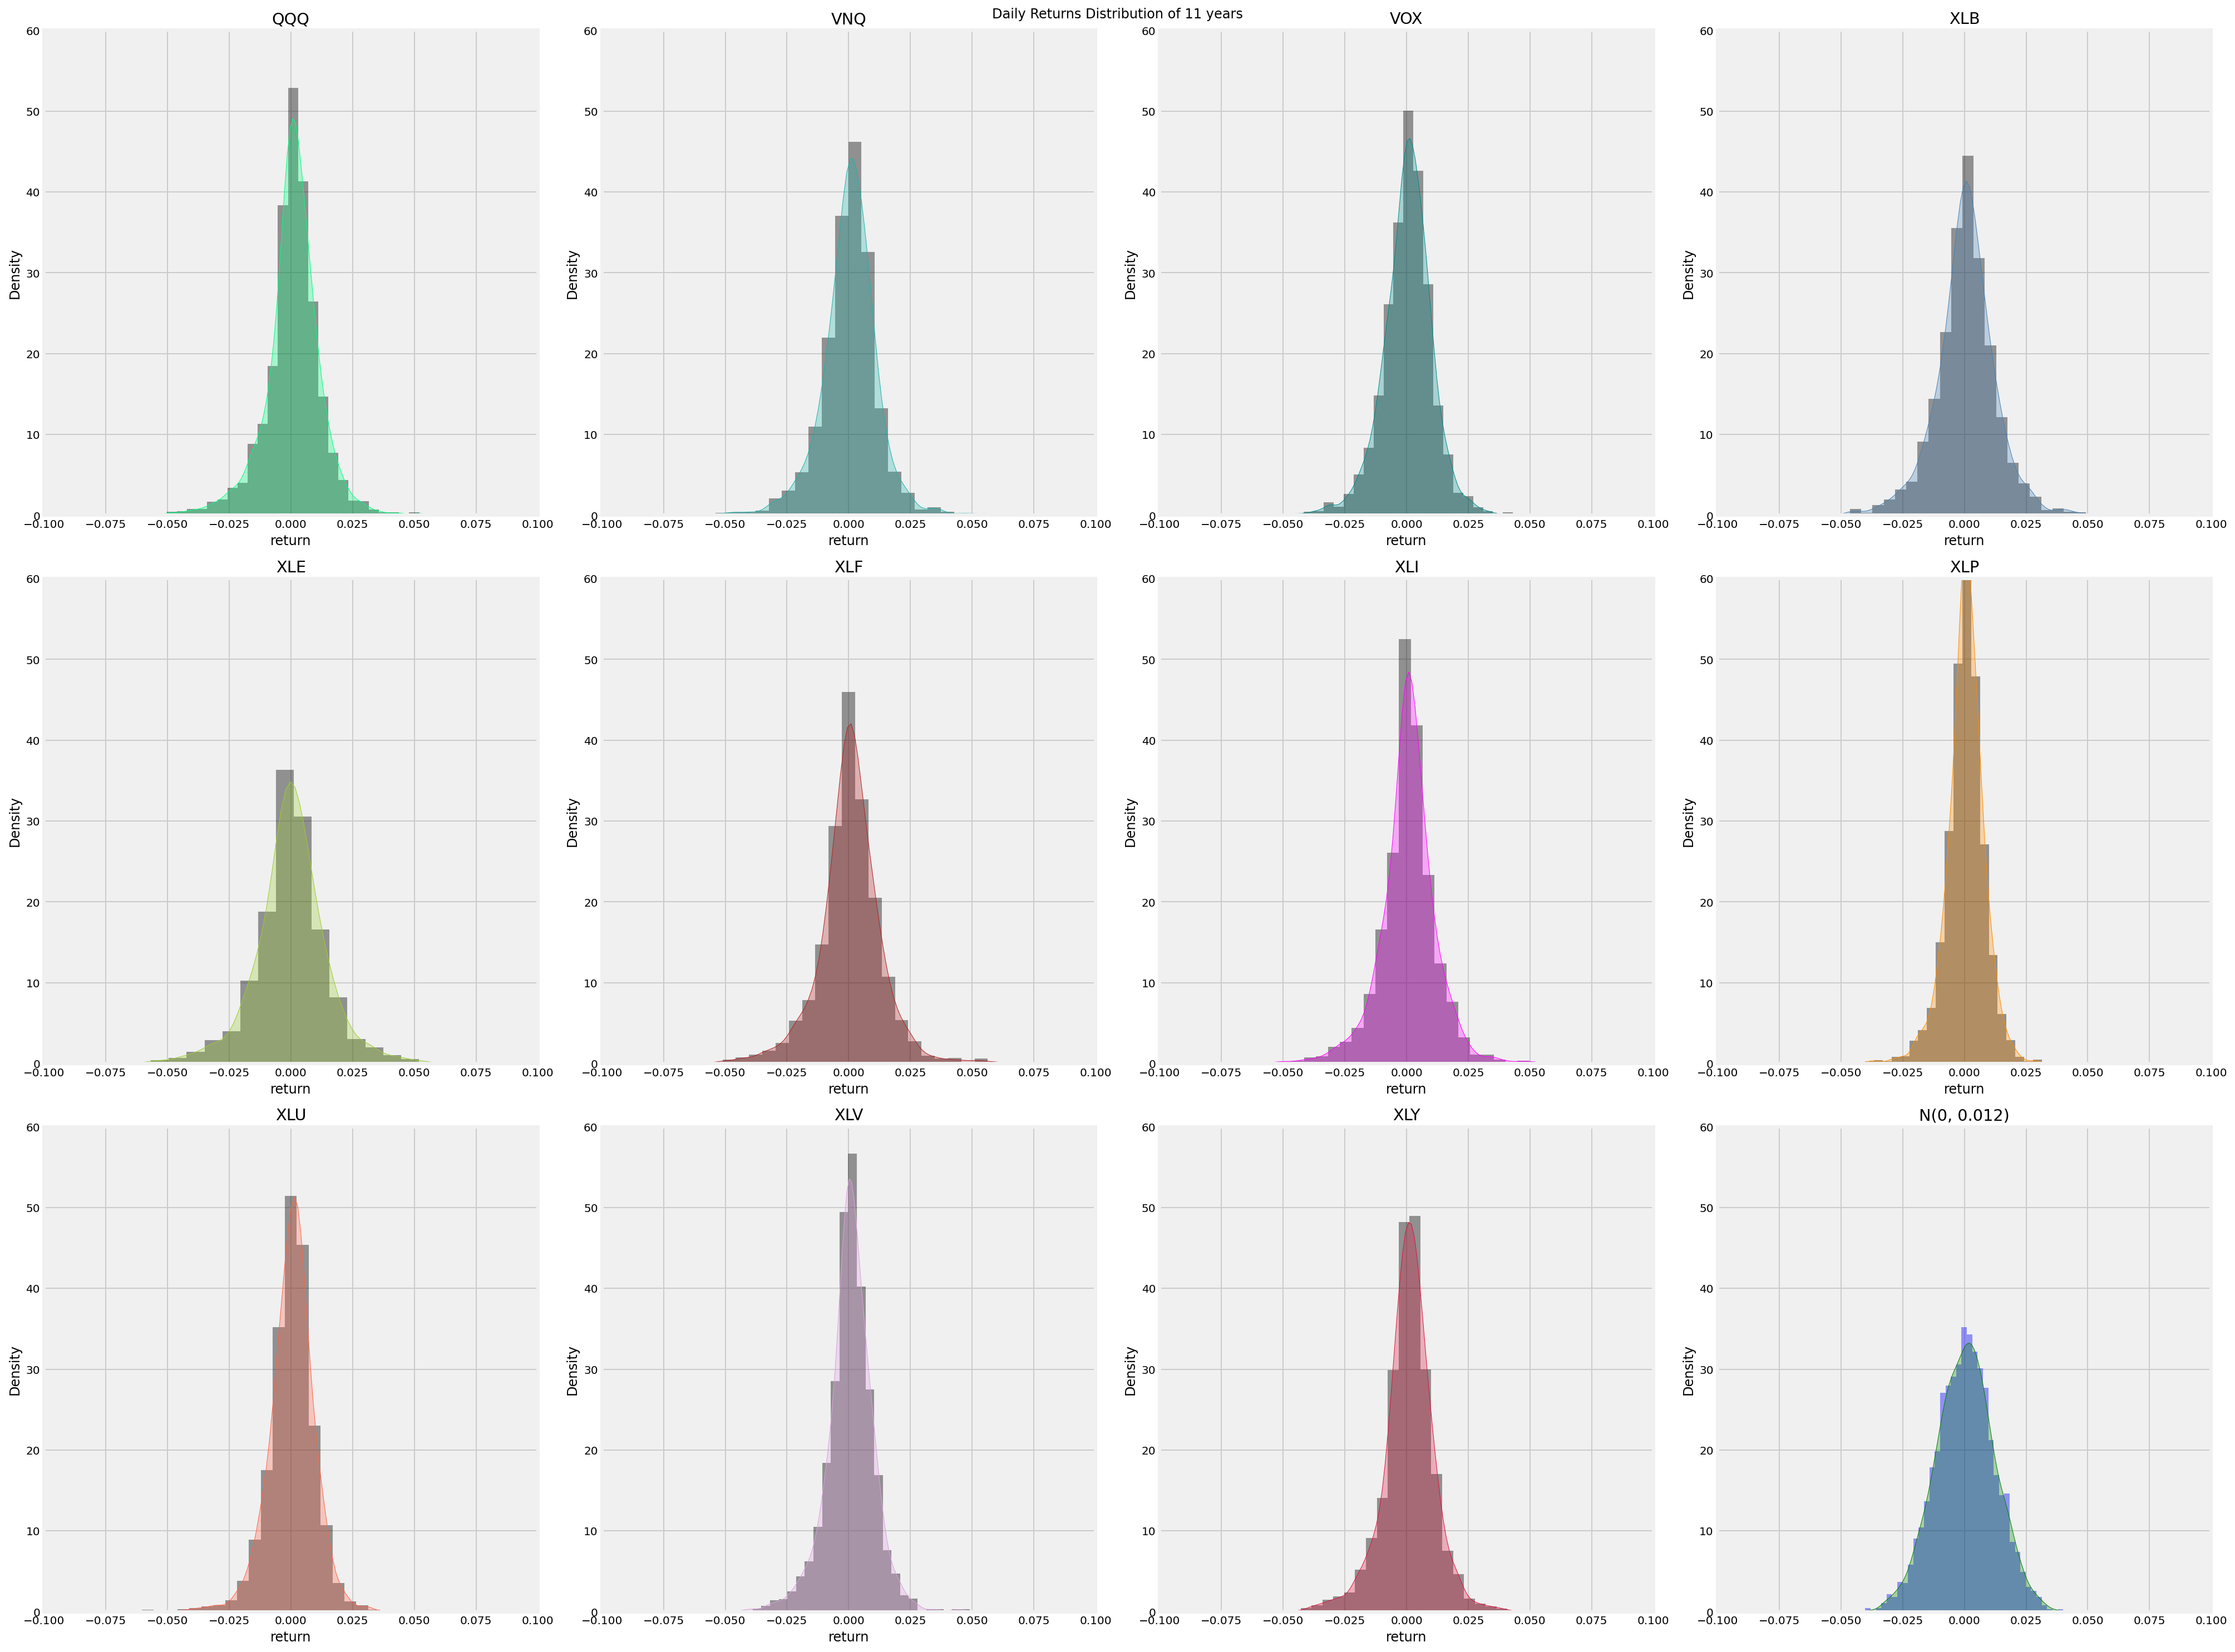

In [21]:
fig, axes = plt.subplots(nrows=3,ncols=4, figsize=(28,21), tight_layout=True)
plt.suptitle("Daily Returns Distribution of 11 years")
for i in range(11):
    data = returns_all_years_panel_data[returns_all_years_panel_data['ticker']==ticker_columns[i]]['return']
    print(f"{ticker_columns[i]}: mean={data.mean()}, se={data.std()}")
    sns.distplot(data, ax = axes[int(i/4)][i%4], color='black', kde=True,kde_kws={"color": colors[i], "alpha":0.3, "linewidth": 0.5, "shade":True })
    axes[int(i/4)][i%4].set_xlim(-0.1, 0.1)
    axes[int(i/4)][i%4].set_ylim(0, 60)
    axes[int(i/4)][i%4].set_title(ticker_columns[i])
normal_dis = np.random.normal(0, 0.012, 3000)
sns.distplot(normal_dis, ax = axes[2][3], color='b', kde=True,kde_kws={"color": 'g', "alpha":0.3, "linewidth": 0.5, "shade":True })
axes[2][3].set_xlim(-0.1, 0.1)
axes[2][3].set_ylim(0, 60)
axes[2][3].set_title("N(0, 0.012)")

KS-test and QQ-plot

QQQ: KstestResult(statistic=0.47887275370009885, pvalue=0.0)
VNQ: KstestResult(statistic=0.4773778072302832, pvalue=0.0)
VOX: KstestResult(statistic=0.4816142315154801, pvalue=0.0)
XLB: KstestResult(statistic=0.47819546508547106, pvalue=0.0)
XLE: KstestResult(statistic=0.473501885148645, pvalue=0.0)
XLF: KstestResult(statistic=0.47560188866988556, pvalue=0.0)
XLI: KstestResult(statistic=0.47806738703090756, pvalue=0.0)
XLP: KstestResult(statistic=0.4849588757595339, pvalue=0.0)
XLU: KstestResult(statistic=0.4822699393598918, pvalue=0.0)
XLV: KstestResult(statistic=0.48137492504260093, pvalue=0.0)
XLY: KstestResult(statistic=0.4811830449842385, pvalue=0.0)


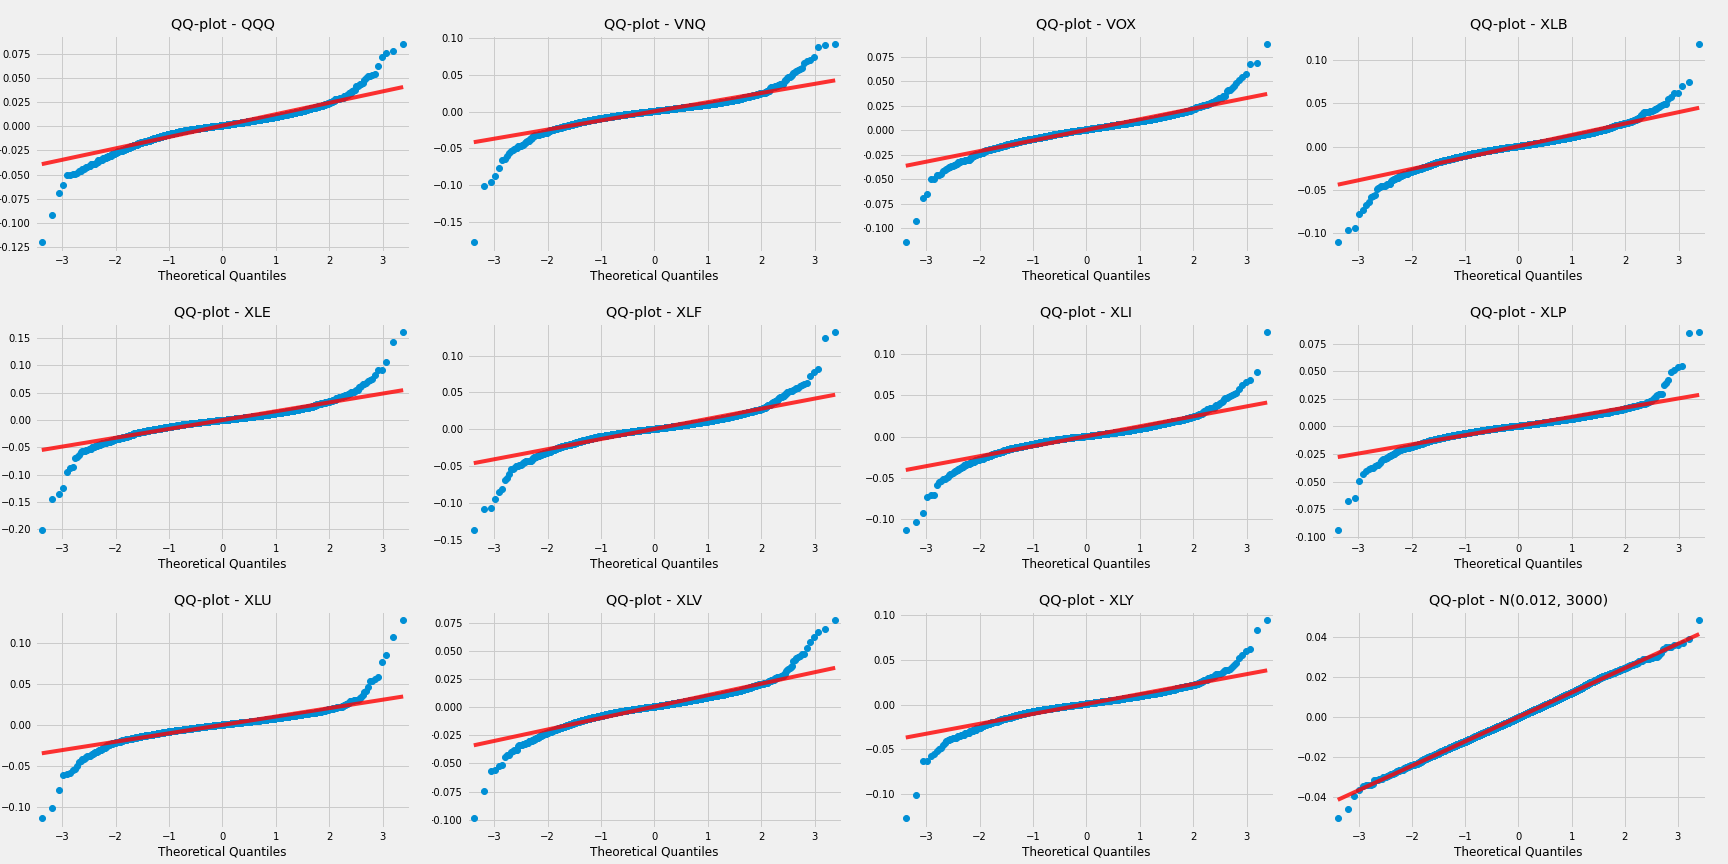

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(11):
    data = returns_all_years_panel_data[returns_all_years_panel_data['ticker']==ticker_columns[i]]['return']
    test_stat = kstest(data, 'norm')
    print(f"{ticker_columns[i]}: {test_stat}")
    fig = sm.qqplot(data, line='r')
    dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
    [d.set_alpha(0.8) for d in dots]
    plt.title(f"QQ-plot - {ticker_columns[i]}")
    plt.savefig(f"./qq-plot-{ticker_columns[i]}.png")
    fig.clear()
normal_dis = np.random.normal(0, 0.012, 3000)
fig = sm.qqplot(normal_dis, line='r')
dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'r')
[d.set_alpha(0.8) for d in dots]
plt.title(f"QQ-plot - N(0.012, 3000)")
plt.savefig(f"./qq-plot-norm.png")
fig.clear()

png_set = [f"qq-plot-{ticker}.png" for ticker in ticker_columns] + ['qq-plot-norm.png']
images = [Image.open(x) for x in png_set]
os.system('rm *.png')
widths, heights = zip(*(i.size for i in images))
total_width = widths[0] * 4 
max_height = heights[0] * 3
new_im = Image.new('RGB', (total_width, max_height))
for i in range(12):
    new_im.paste(images[i], ((i%4) * widths[0], min(int(i/4), 2)*heights[0]))
new_im.save('QQ-plot.png')
display.Image("./QQ-plot.png")

#### 2.2 Correlation

In [23]:
returns_corr_matrix_all_years = returns_all_years_ts_data.corr()
returns_corr_matrix_one_year = returns_one_year_ts_data.corr()

<AxesSubplot:title={'center':'11 Years'}>

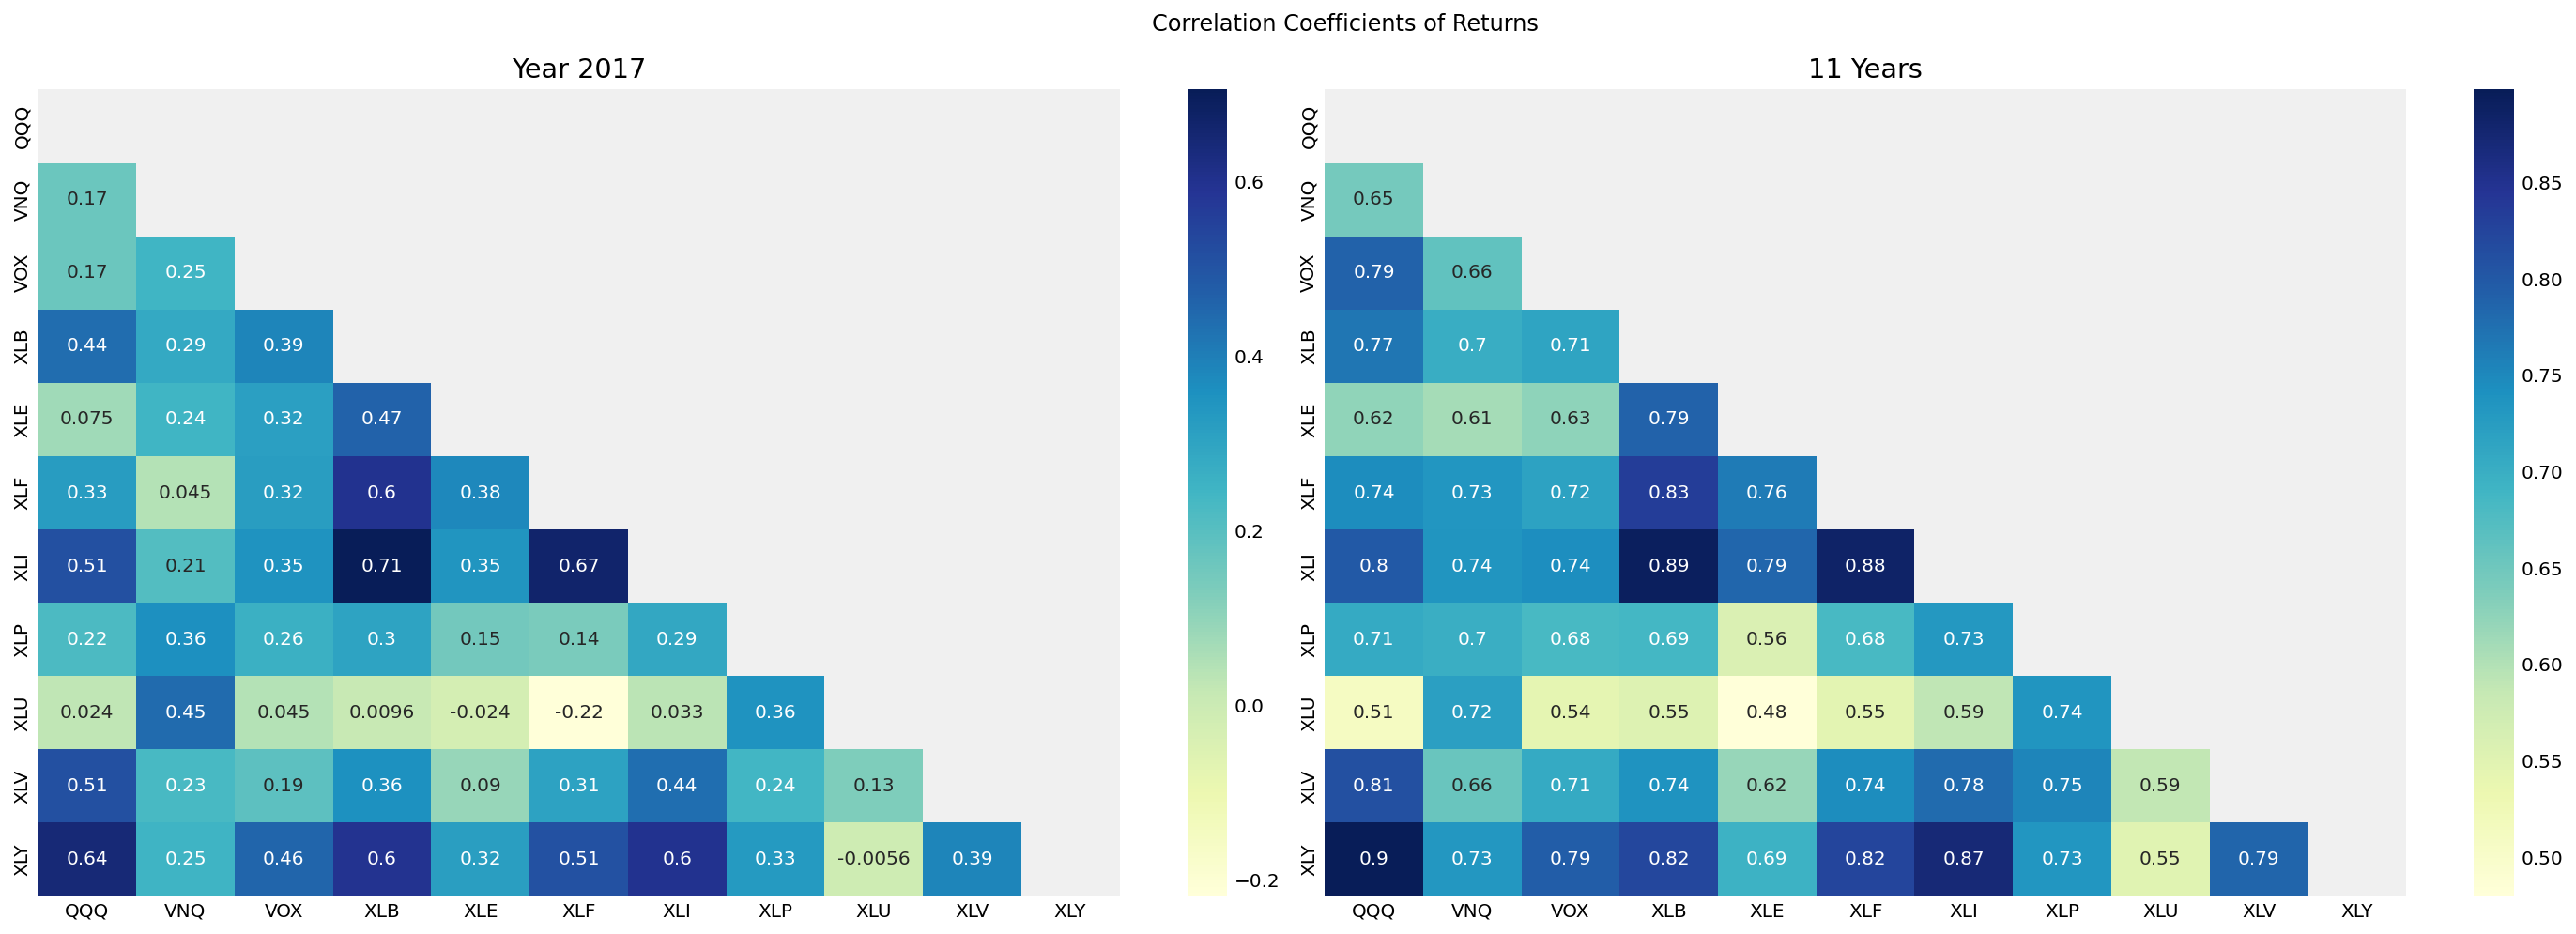

In [24]:
mask = np.zeros_like(price_corr_matrix_one_year)
mask[np.triu_indices_from(mask)] = True
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7), tight_layout = True)
plt.suptitle("Correlation Coefficients of Returns")
axes[0].set_title(f"Year {individual_year}")
sns.heatmap(returns_corr_matrix_one_year, ax=axes[0], mask=mask, annot=True, cmap="YlGnBu")
axes[1].set_title("11 Years")
sns.heatmap(returns_corr_matrix_all_years, ax=axes[1], mask=mask, annot=True, cmap="YlGnBu")

### 🎲3. Risk

In [25]:
month_end_returns = []
month_sd = []

In [26]:
returns_all_years_ts_data['Y-M'] = list(pd.Series(returns_all_years_ts_data.index).apply(lambda x: x[:7]))
returns_groups = returns_all_years_ts_data.groupby('Y-M')

In [27]:
returns_all_years_ts_data.head()

QQQ       VNQ       VOX       XLB       XLE       XLF  \
Date                                                                     
2010-01-05  0.000000 -0.001122  0.006757  0.003233  0.008231  0.018441   
2010-01-06 -0.006057 -0.001798 -0.015832  0.016994  0.011985  0.001646   
2010-01-07  0.000653  0.010806 -0.003672 -0.007779 -0.001545  0.021364   
2010-01-08  0.008264 -0.007350 -0.004563  0.013937  0.006533 -0.005632   
2010-01-11 -0.004098  0.005834  0.000882 -0.005441 -0.001366  0.000809   

                 XLI       XLP       XLU       XLV       XLY      Y-M  
Date                                                                   
2010-01-05  0.003531  0.000375 -0.011905 -0.009869  0.003667  2010-01  
2010-01-06  0.002111 -0.000750  0.005861  0.010289  0.001328  2010-01  
2010-01-07  0.010885  0.000000 -0.004532  0.003183  0.008292  2010-01  
2010-01-08  0.015978 -0.003376 -0.000976  0.001586 -0.000329  2010-01  
2010-01-11  0.010940  0.002635  0.010417  0.005702 -0.001974  2010-01

In [28]:
end_returns = list(returns_groups.get_group("2010-01").iloc[-1, :-1].astype(float))
end_sd = list(returns_groups.get_group("2010-01").iloc[:, :-1].astype(float).std())
months_end_r_sd_panel_data  = pd.DataFrame({"ticker": ticker_columns, "mon_end_return": end_returns, "mon_sd": end_sd})

In [29]:
for mon in mons[1:]:
    end_returns = list(returns_groups.get_group(mon).iloc[-1, :-1].astype(float))
    end_sd = list(returns_groups.get_group(mon).iloc[:, :-1].astype(float).std())
    months_end_r_sd_panel_data = months_end_r_sd_panel_data.append(pd.DataFrame({"ticker": ticker_columns, "mon_end_return": end_returns, "mon_sd": end_sd}), ignore_index=True)

In [30]:
months_end_r_sd_panel_data

ticker  mon_end_return    mon_sd
0       QQQ       -0.017524  0.012547
1       VNQ       -0.005646  0.013573
2       VOX       -0.006669  0.009071
3       XLB       -0.015997  0.015851
4       XLE       -0.018000  0.011032
...     ...             ...       ...
1447    XLI        0.004652  0.006874
1448    XLP        0.007017  0.006668
1449    XLU        0.014892  0.009208
1450    XLV        0.010511  0.006797
1451    XLY        0.000560  0.006085

[1452 rows x 3 columns]

In [31]:
df = months_end_r_sd_panel_data.sample(frac=1, random_state=1)

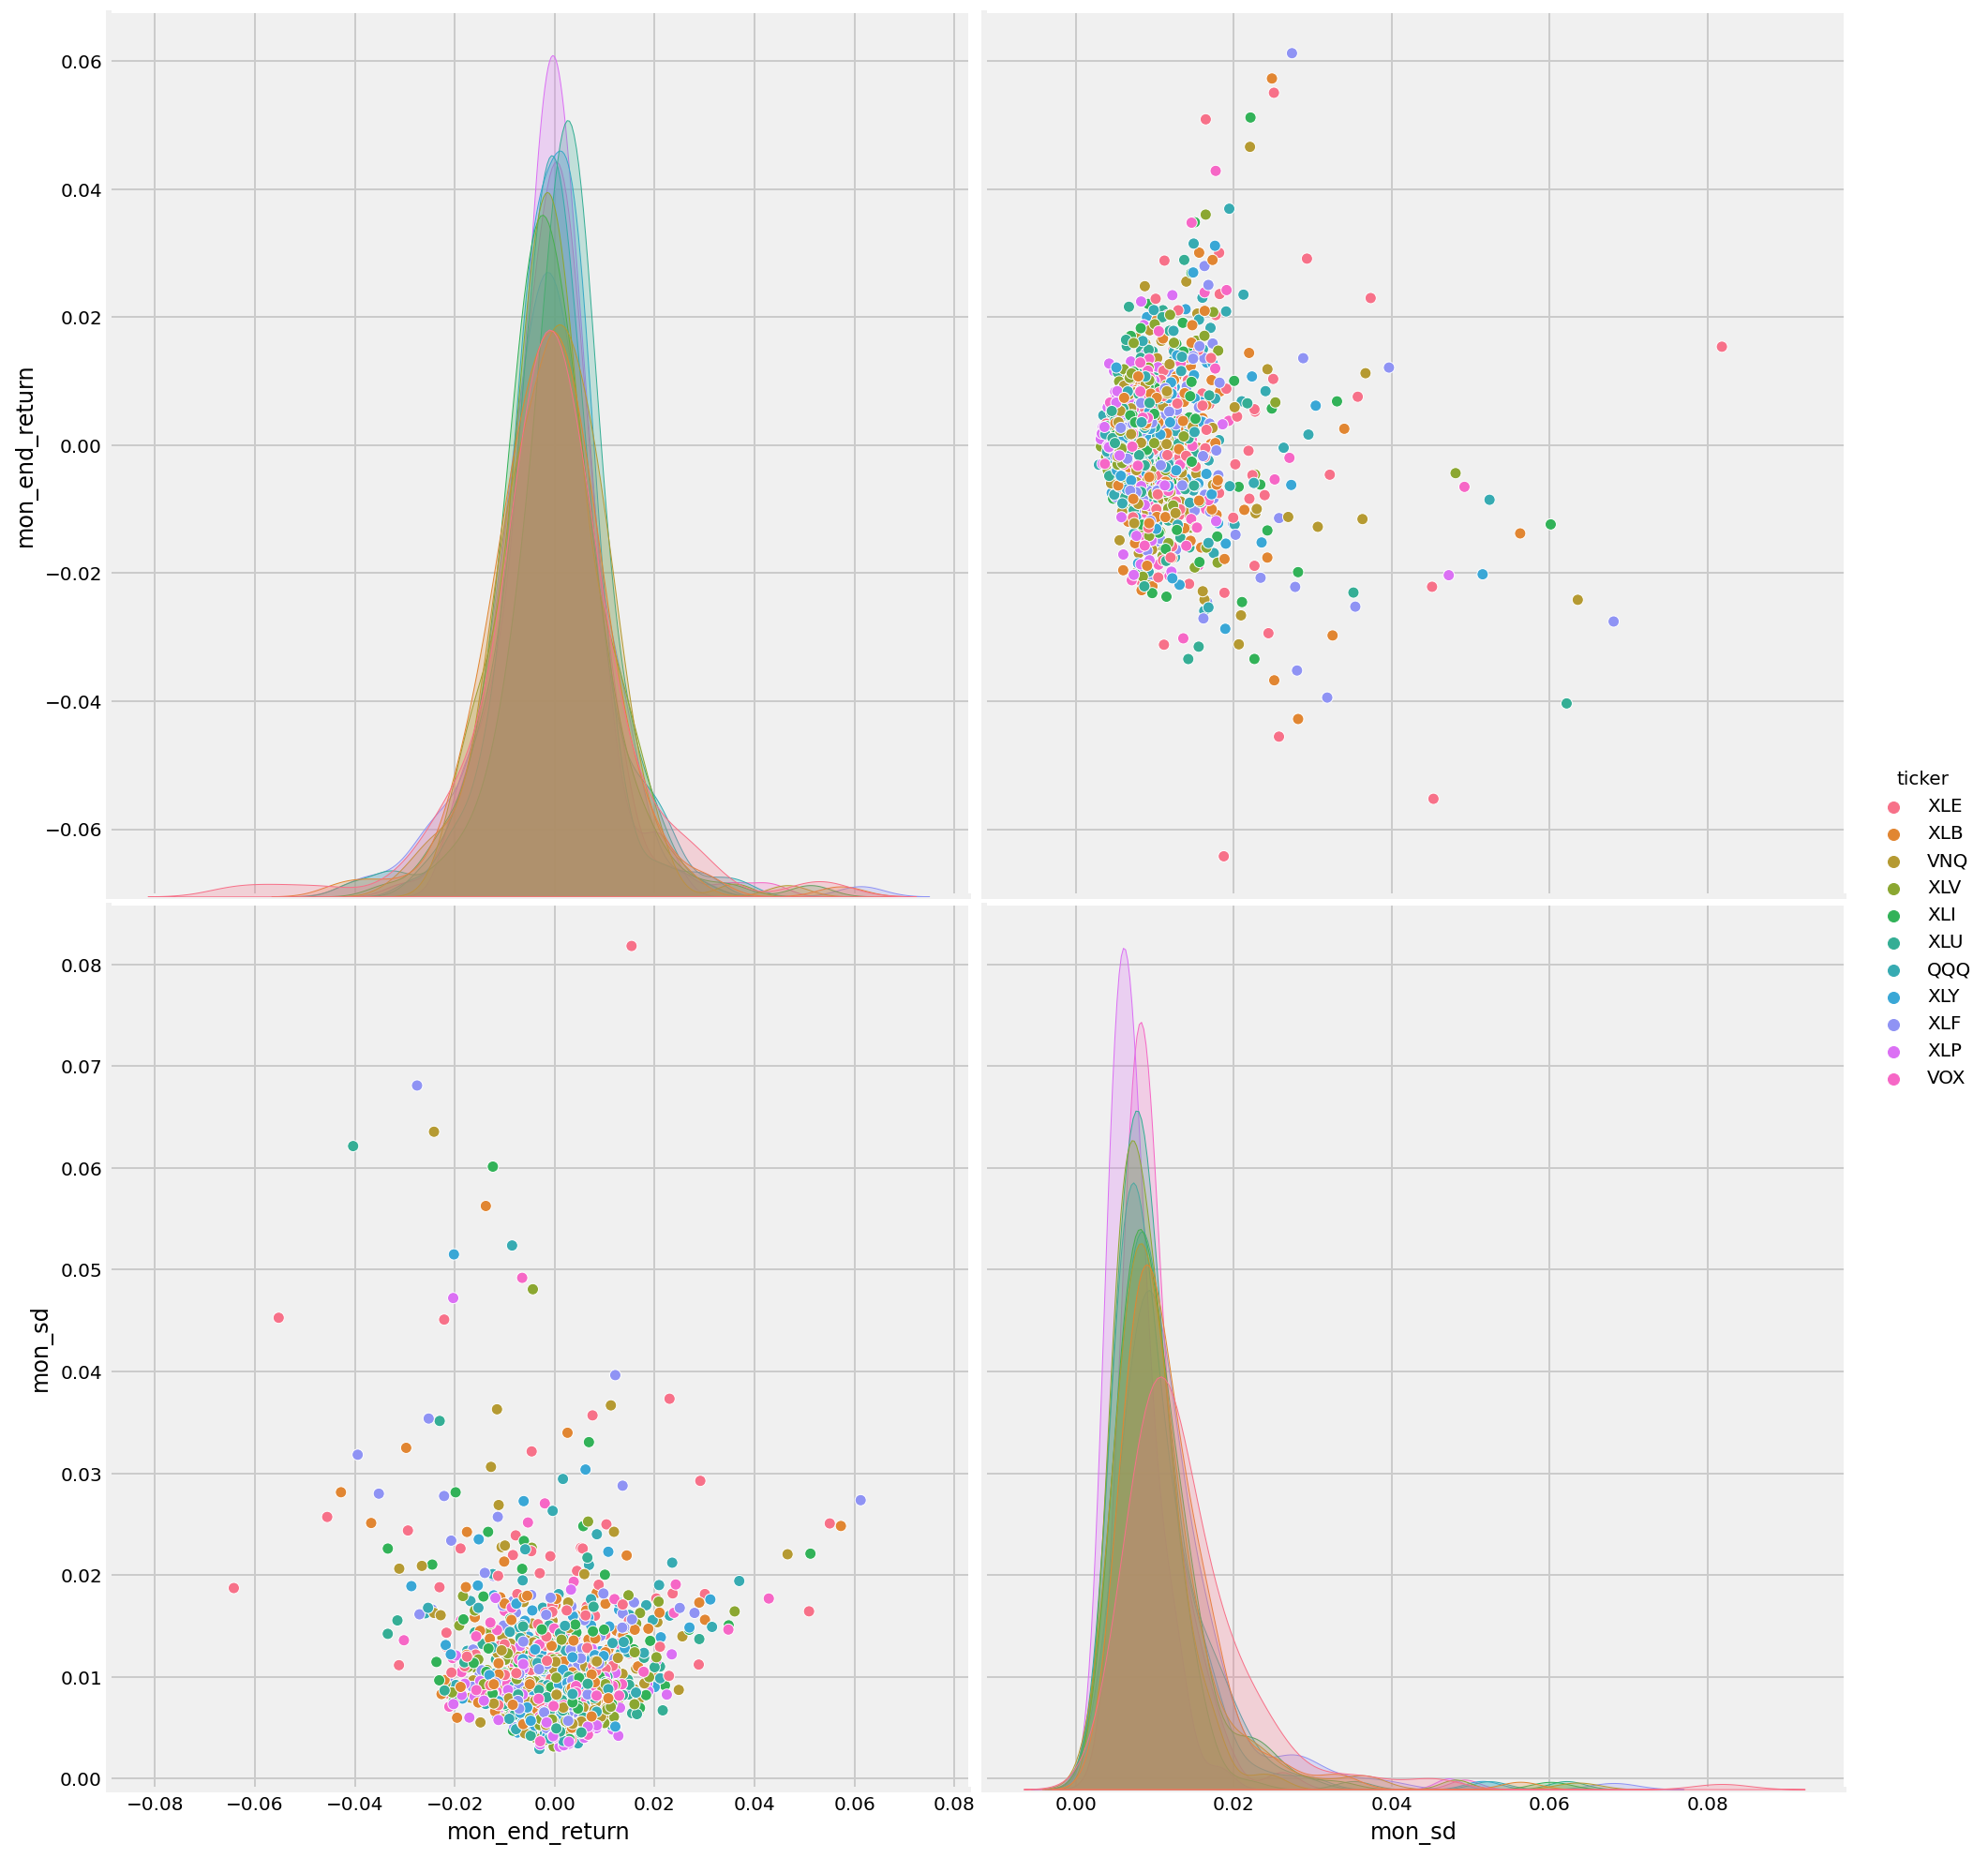

In [32]:
height = 7
sns.color_palette(colors)
sns.pairplot(df, hue = "ticker", height=height, aspect = 7/height)

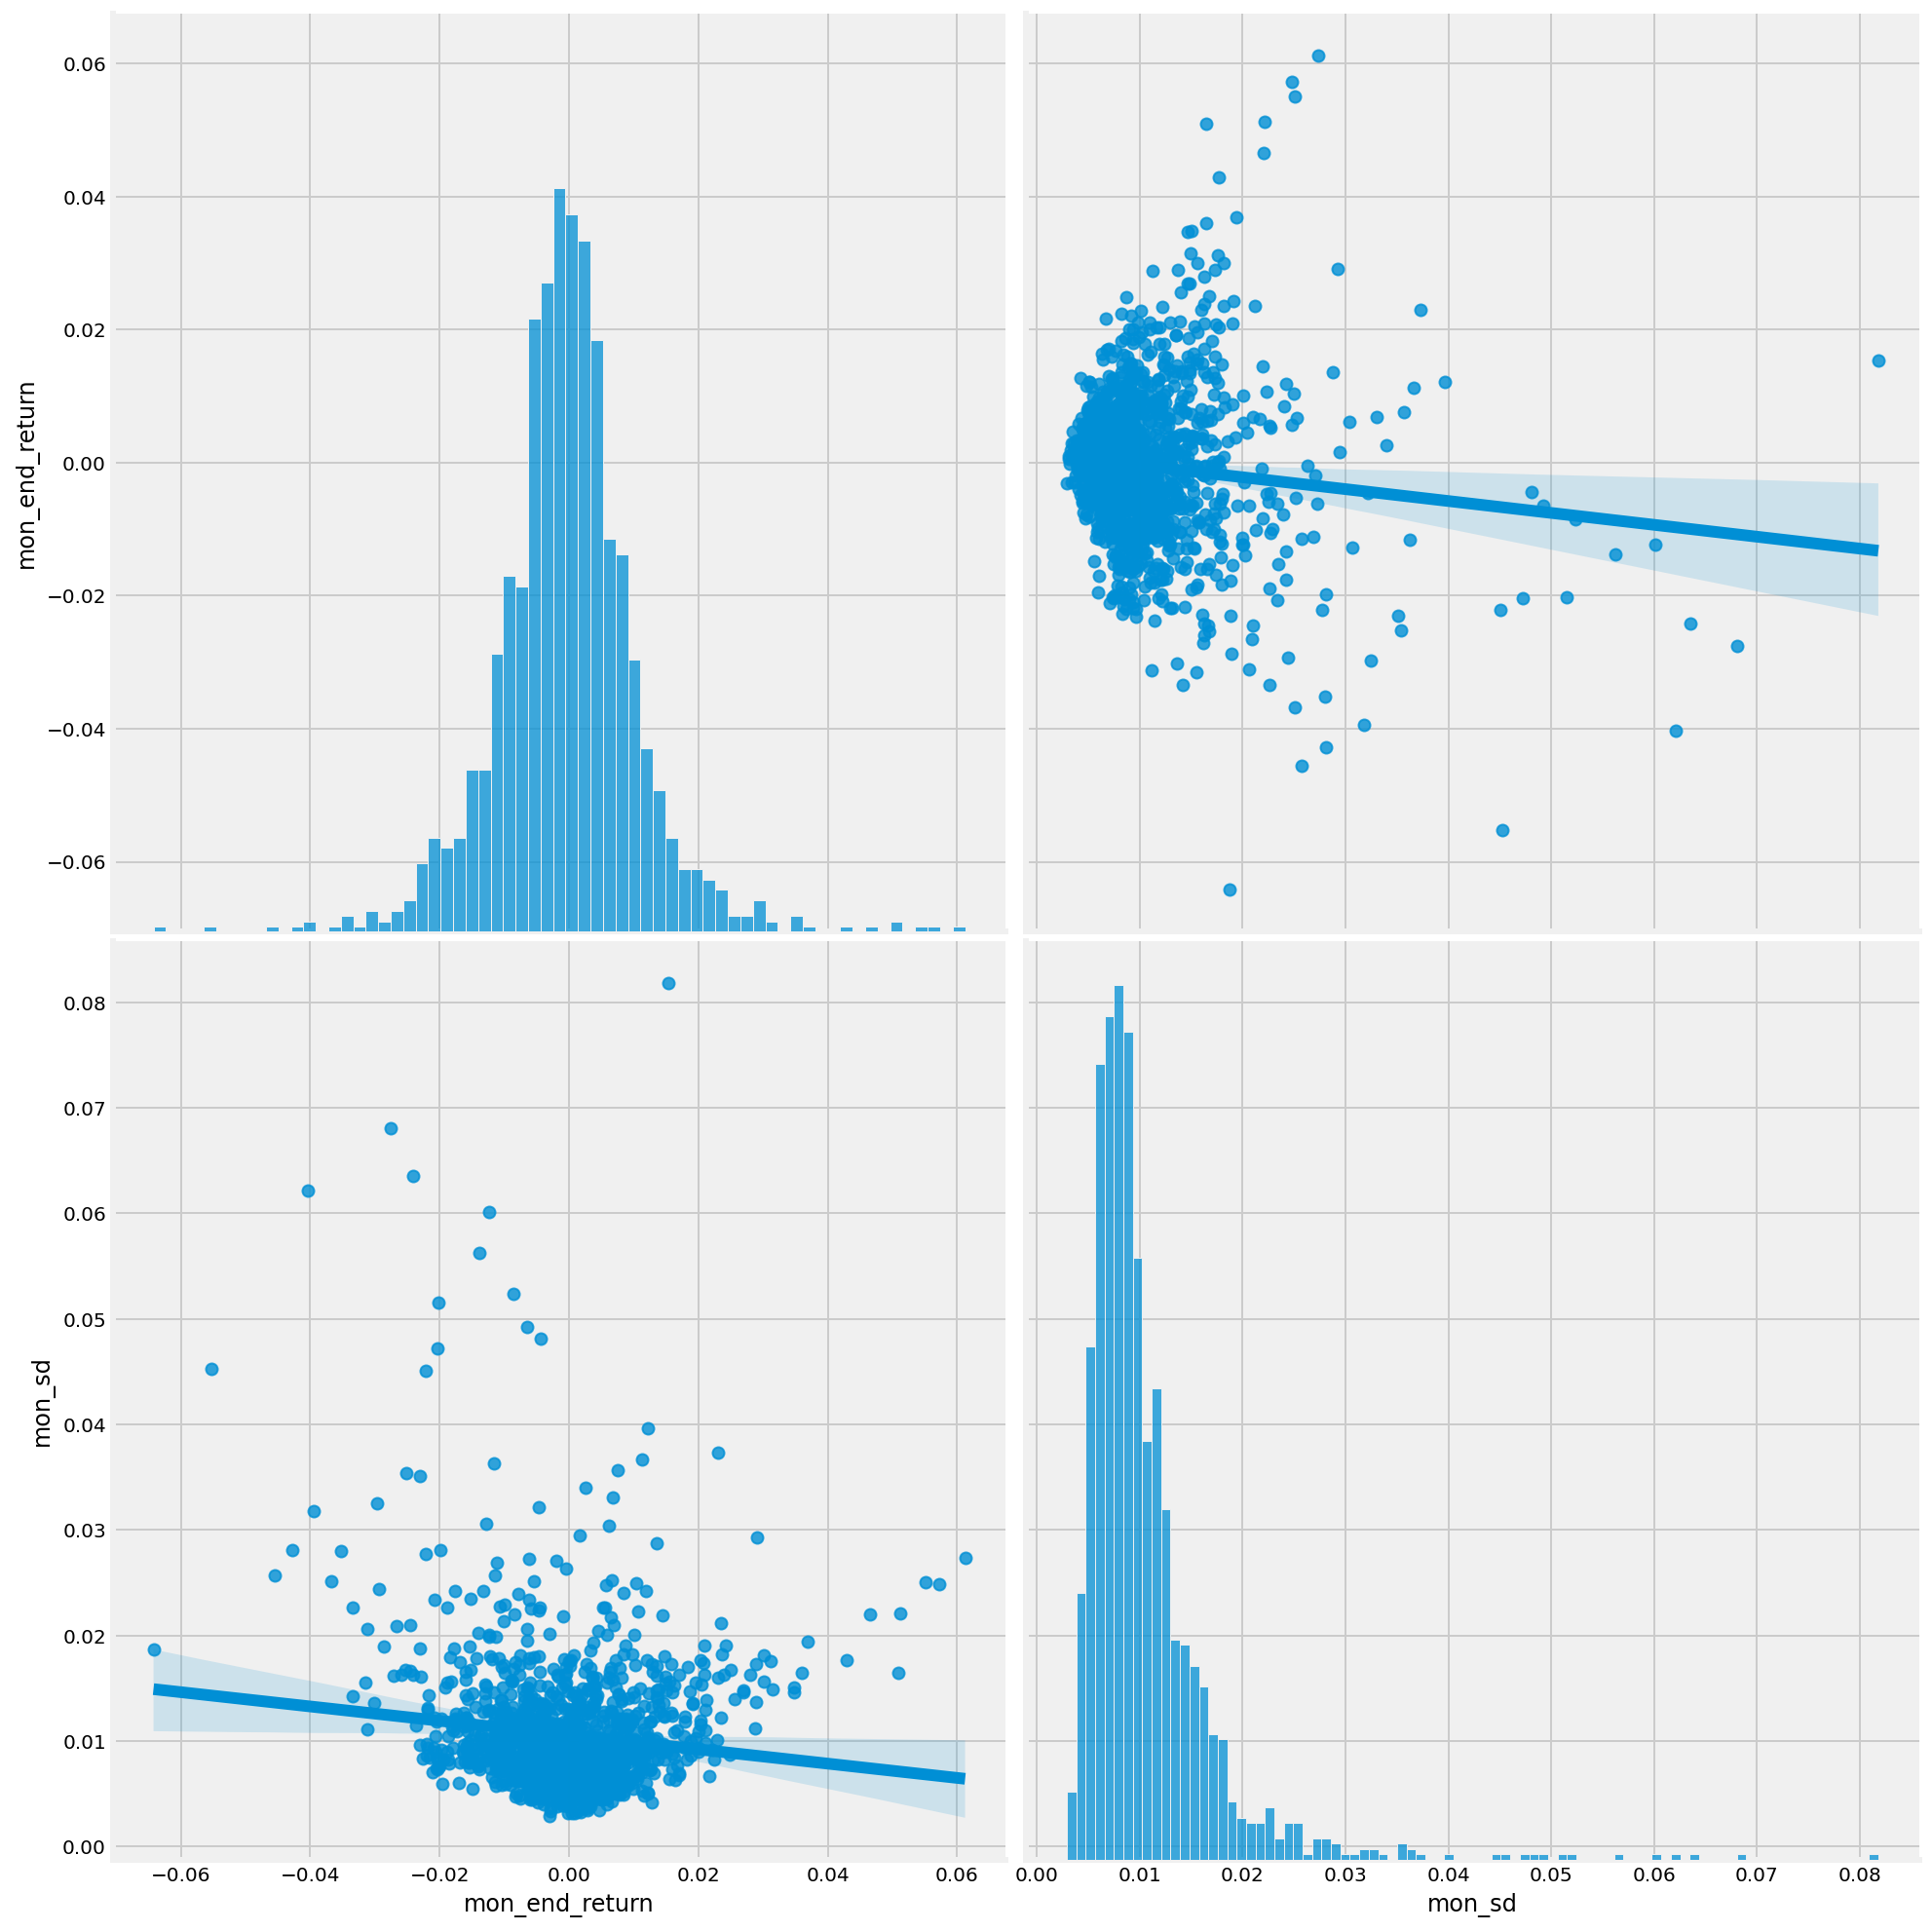

In [33]:
height = 7
sns.color_palette(colors)
sns.pairplot(df, kind = 'reg', height=height, aspect = 7/height)